# Demo Notebook - Lecture 10

Clustering algorithms are important techniques for structural discovery in the data. In this lecture, we will first compare two prominent clustering algorithms as well as heuristics for obtaining the optimal number of clusters on simulated data. In the second part, we will use the flipped classroom data as a real-world use case.

In [1]:
#Important imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import distance
from scipy.sparse.csgraph import laplacian
from scipy import linalg

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, rand_score
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import spectral_embedding

# Data directory
DATA_DIR = "./../../data"

## K-Means Clustering

K-Means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. K-means clustering minimizes within-cluster variances (squared Euclidean distances). In a first step, we look at K-Means clustering in detail. We first generate a synthetic example data set and write a function able to extract the intermediate cluster assignments from the K-Means algorithm. 

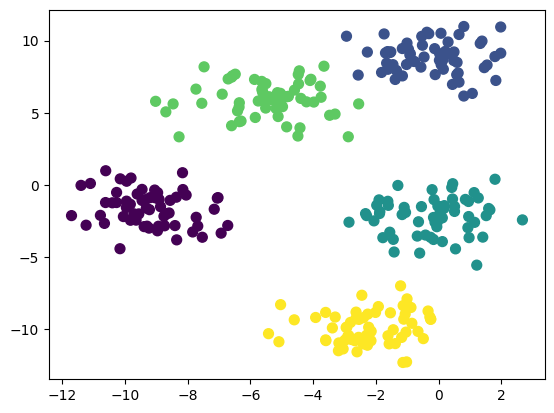

In [2]:
n_samples = 300
X, y= make_blobs(n_samples=n_samples, centers=5,
                cluster_std=1.2, random_state=2010)
plt.scatter(X[:, 0], X[:, 1], s=50, c=y)

In [3]:
def getKMeansSteps(X, k, centroids):

    y_pred = []
    intermediate_centers = []
    k_means = KMeans(n_clusters=k, max_iter=1, init=centroids, n_init=1)
    c_hat = centroids
    for i in range(100):
        intermediate_centers.append(c_hat)
        y_hat = k_means.fit_predict(X)
        c_hat = k_means.cluster_centers_
        y_pred.append(y_hat)
        k_means = KMeans(n_clusters=k, max_iter=1, init=c_hat, n_init=1)
    
    return y_pred, intermediate_centers

In [4]:
c1 = np.array([[-9,-2], [-6, 8], [0, 6], [0, -5], [-2, -10]])
y_pred_1, centers_1 = getKMeansSteps(X, 5, c1)

In [5]:
c2 = np.array([[-9,-2], [-6, 8], [0, -5], [-2, -10]])
y_pred_2, centers_2 = getKMeansSteps(X, 4, c2)

In [6]:
c3 = np.array([[-9,-2], [-7, 5], [-6, 5], [0, 10], [2, -10]])
y_pred_3, centers_3 = getKMeansSteps(X, 5, c3)

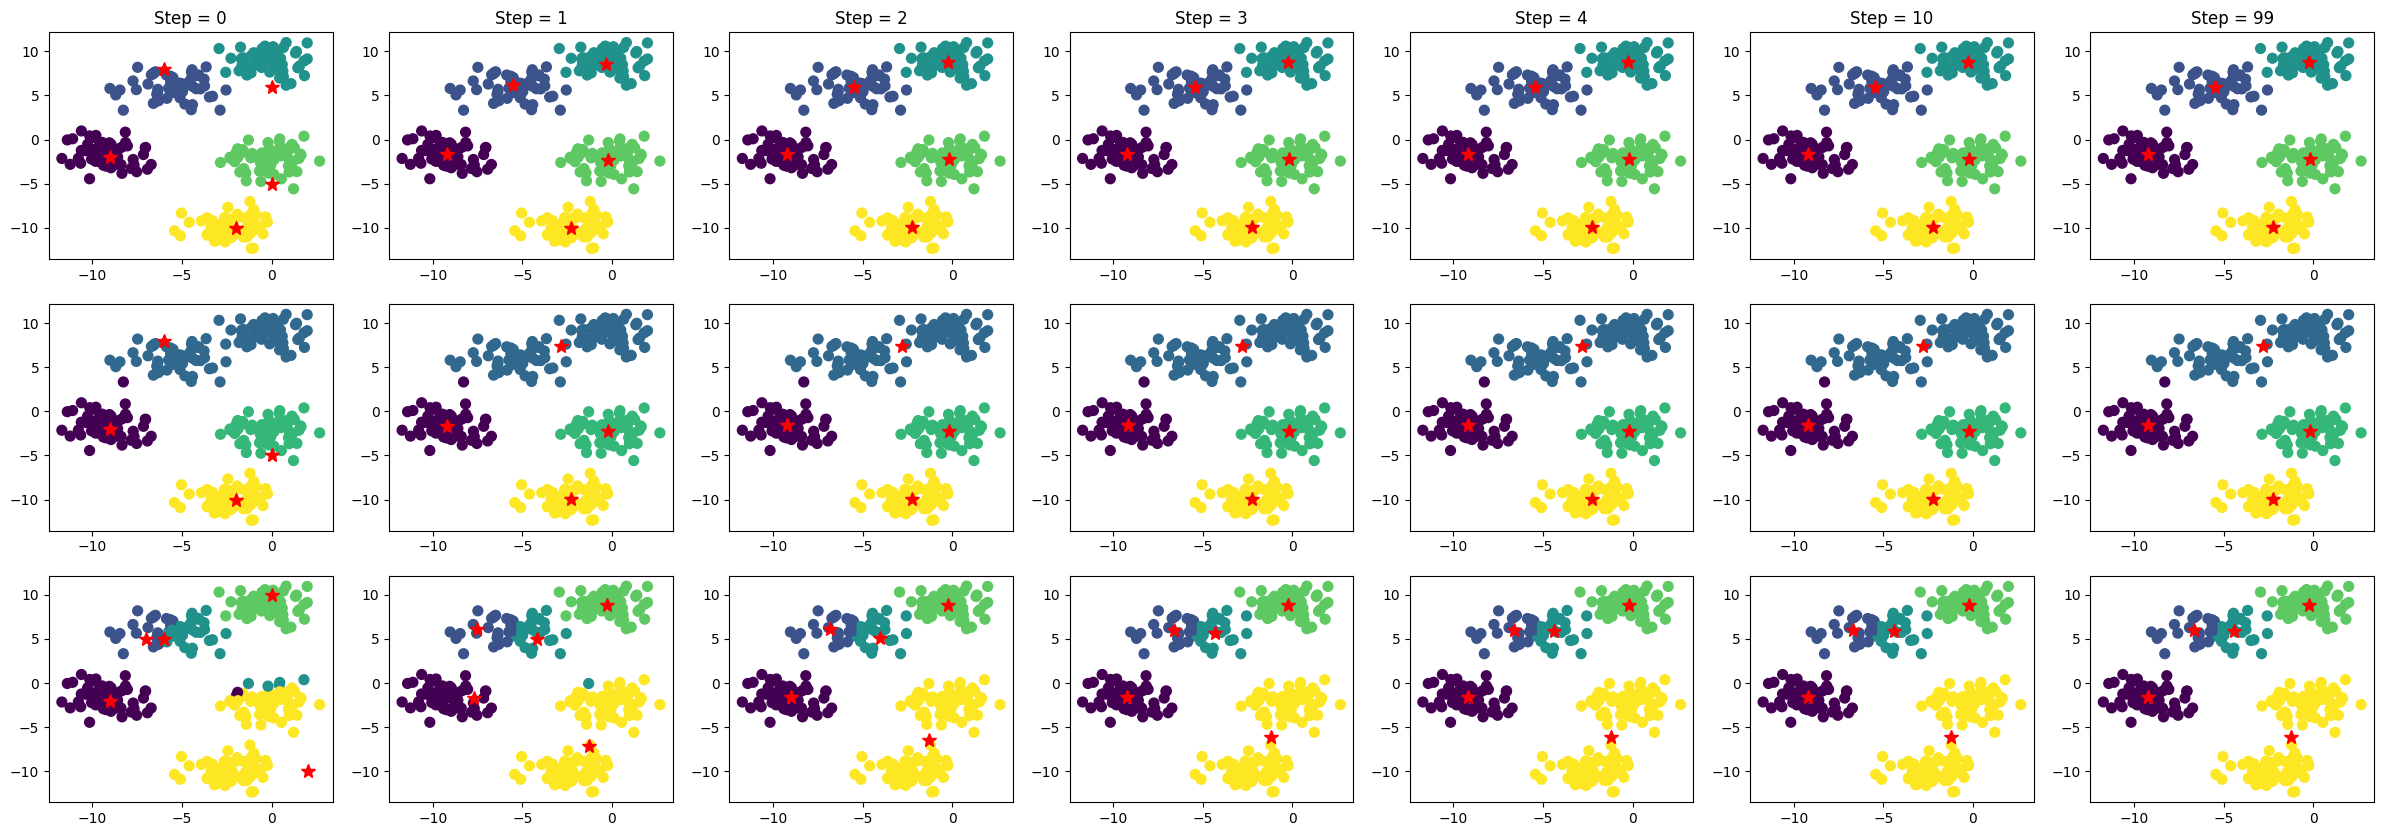

In [7]:
steps = [0, 1, 2, 3, 4, 10, 99]

fig, ax = plt.subplots(3, 7, figsize=(30, 10))

ind = 0
for i in steps:
    ax[0,ind].scatter(X[:, 0], X[:, 1], s=50, c = y_pred_1[i]);
    ax[0,ind].plot(centers_1[i].transpose()[0], centers_1[i].transpose()[1], marker='*', color = 'red', ls='none', ms=10)
    ax[0,ind].set_title('Step = ' + str(i))
    ind = ind+1
    
ind = 0
for i in steps:
    ax[1,ind].scatter(X[:, 0], X[:, 1], s=50, c = y_pred_2[i]);
    ax[1,ind].plot(centers_2[i].transpose()[0], centers_2[i].transpose()[1], marker='*', color = 'red', ls='none', ms=10)
    ind = ind+1
    
ind = 0
for i in steps:
    ax[2,ind].scatter(X[:, 0], X[:, 1], s=50, c = y_pred_3[i]);
    ax[2,ind].plot(centers_3[i].transpose()[0], centers_3[i].transpose()[1], marker='*', color = 'red', ls='none', ms=10)
    ind = ind+1
    
plt.show()

We observe that the final cluster solution depends on the position of the initial centroids as well as on the number of clusters chosen.

Next, we generate a well separable data set with k=4 clusters and run K-Means with the correct cluster number. Note that the scikit-learn implementation of k-means by default uses random ten random re-starts (and then chooses the cluster solution resulting in the lowest distortion).

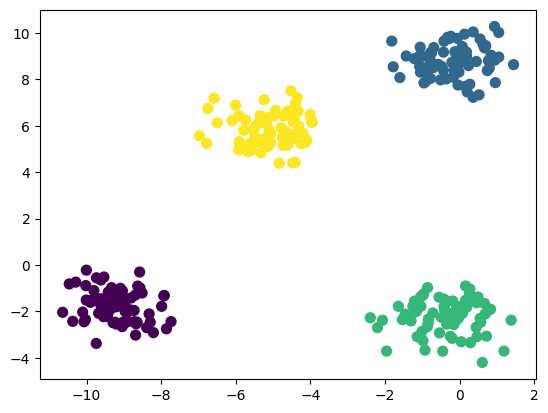

In [8]:
X_blobs, y_blobs = make_blobs(n_samples=n_samples, centers=4,
                              cluster_std=0.7, random_state=2010)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], s=50, c=y_blobs)

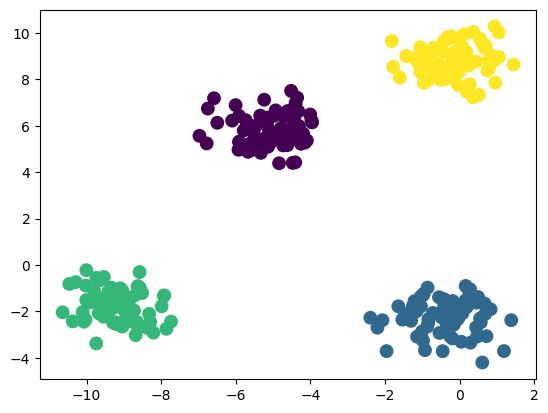

In [9]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=111)
y_blobs_pred = kmeans.fit_predict(X_blobs)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], s=80, c = y_blobs_pred);

Of course, when not dealing with simulated data, we normally do not know the cluster number a-priori. Next, we therefore run K-Means for k = 2,...,10 clusters. We then compute different heuristics to find the optimal number of clusters:
- Elbow method (distortion plot)
- Silhouette score
- BIC

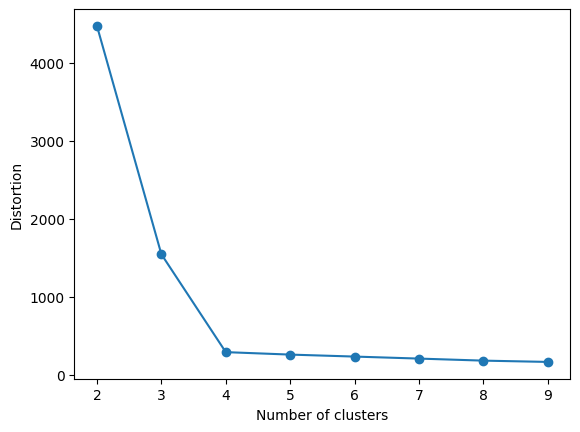

In [10]:
def plot_distortion(n_clusters_list, X):
    """
    Plot the distortion (in-cluster variance) on the y-axis and 
    the number of clusters in the x-axis 
    
    :param n_clusters_list: List of number of clusters to explore
    :param X: np array of data points 
    """
    distortion_list = []
    for k in n_clusters_list:
        kmeans = KMeans(n_clusters=k, random_state=111).fit(X)
        distortion = kmeans.inertia_
        distortion_list.append(distortion)

    plt.plot(n_clusters_list, distortion_list, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    
    
n_clusters_list = range(2, 10)    
plot_distortion(n_clusters_list, X_blobs)

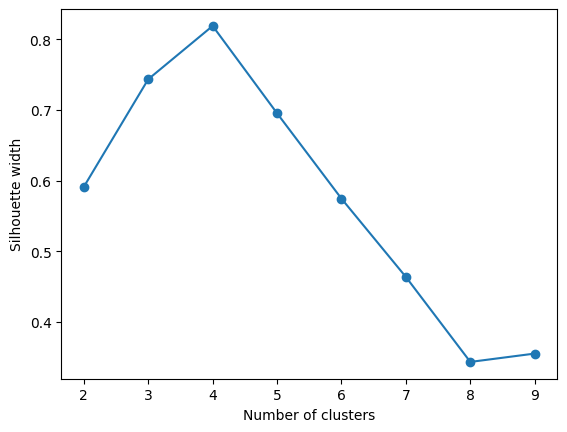

In [11]:
def plot_silhouette(n_clusters_list, X):
    """
    Plot the silhouette score on the y-axis and
    the number of clusters in the x-axis
    :param n_clusters_list: List of number of clusters to explore
    :param X: np array of data points 
    """
    silhouette_list = []
    for k in n_clusters_list:
        kmeans = KMeans(n_clusters=k, random_state=111)
        y_pred = kmeans.fit_predict(X)
        silhouette = silhouette_score(X, y_pred)
        silhouette_list.append(silhouette)

    plt.plot(n_clusters_list, silhouette_list, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette width')


plot_silhouette(n_clusters_list, X_blobs)

In [12]:
def compute_bic(kmeans, X, clustering_method='kmeans'):
    """
    Computes the BIC metric

    :param kmeans: clustering object from scikit learn
    :param X: np array of data points
    :return: BIC
    """
    # Adapted from: https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans

    # number of clusters
    k = kmeans.n_clusters
    labels = kmeans.labels_
    
    if clustering_method=='spectral':
        centers = [np.array([np.mean(X[labels==i], axis=0) for i in range(k)])]
    else:
        centers = [kmeans.cluster_centers_]
        
    # size of the clusters
    n = np.bincount(labels)
    # size of data set
    N, D = X.shape

    # compute variance for all clusters beforehand
    cl_var = (1.0 / (N - k) / D) * sum([sum(distance.cdist(X[np.where(labels == i)], \
                                    [centers[0][i]],'euclidean') ** 2) for i in range(k)])


    LL = np.sum([n[i] * np.log(n[i]) -
                  n[i] * np.log(N) -
                  ((n[i] * D) / 2) * np.log(2 * np.pi * cl_var) -
                  ((D / 2)*(n[i] - 1))  for i in range(k)])
    
    d = (k - 1) + 1 + k * D
    const_term = (d / 2) * np.log(N)
    
    BIC = LL - const_term
    
    return BIC


kmeans = KMeans(n_clusters=4, random_state=111).fit(X_blobs)
bic = compute_bic(kmeans, X_blobs)

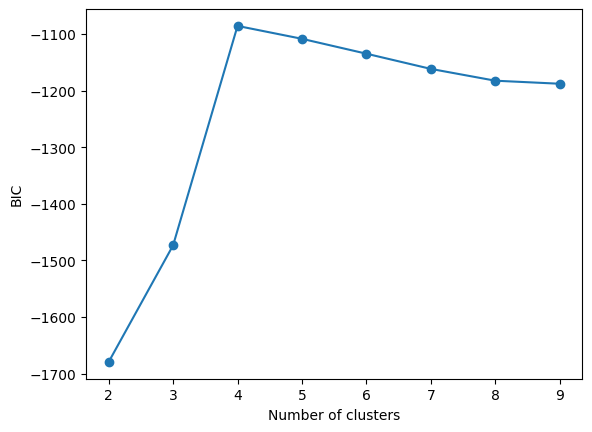

In [13]:
def plot_bic(n_clusters_list, X):
    """
    Plot the BIC on the y-axis and the number of clusters in the x-axis
    :param n_clusters_list: List of number of clusters to explore
    :param X: np array of data points 
    """
    bic_list = []
    for k in n_clusters_list:
        kmeans = KMeans(n_clusters=k, random_state=111).fit(X)
        bic = compute_bic(kmeans, X)
        bic_list.append(bic)

    plt.plot(n_clusters_list, bic_list, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC')


plot_bic(n_clusters_list, X_blobs)

We observe that all three heuristics are able to recover the correct number of clusters (k=4).

## Spectral Clustering

K-Means is based on the assumption that the samples lie in a Euclidean space, i.e. that the points with a smaller Euclidean distance belong to the same cluster, and that the variance around each cluster is spherical. This might lead to problems in practice. To illustrate this, we generate a synthetic data set with two clusters that are not linearly separable in a 2-D Euclidean space.

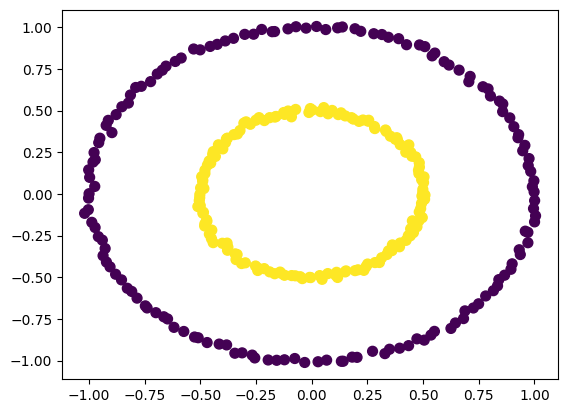

In [14]:
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.5, noise=.01, random_state=111)
plt.scatter(X_circles[:, 0], X_circles[:, 1], s=50, c = y_circles)
plt.show()

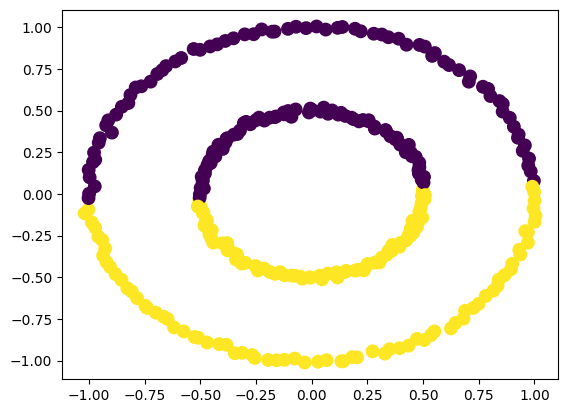

In [15]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=111)
y_circles_pred = kmeans.fit_predict(X_circles)
plt.scatter(X_circles[:, 0], X_circles[:, 1], s=80, c = y_circles_pred);

We observe that due to its assumptions, K-Means is not able to retrieve the correct clusters.

In contrast to K-Means, spectral clustering makes no assumption about the form/shape of the clusters. The different data points are treated as nodes of graphs and the clustering is done based on connectivity of the graph. In a first step, we use spectral clustering to cluster the two simulated data sets. We again assume that the correct number of clusters is known a-priori. We will use an unnormalized Laplacian for all our experiments.

We compute the pairwise similarity matrix using the radial basis function or Gaussian kernel, defined as:

$$s_{ij} = s\left(\boldsymbol{x_i}, \boldsymbol{x_j}\right) = \exp(-\gamma ||\boldsymbol{x_i} - \boldsymbol{x_j}||^2)$$

where $\gamma$ is a hyperparameter that must be tuned, controlling the width of the kernel.

In [16]:
def get_similarity(X, gamma = 1):
    """
    Computes the similarity matrix
    :param X: np array of data
    :param gamma: the width of the kernel
    :return: similarity matrix
    """
    
    similarity = pairwise_kernels(X, metric='rbf', gamma=gamma)
    
    return similarity

We then compute the adjacency matrix W based on the similarity. 

In [17]:
def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity 
    :return: adjacency matrix
    """
    
    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')
        
    return adjacency

Next, we can implement the spectral clustering algorithm.

In [18]:
def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :param normed: normalized or unnormalized Laplacian
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues 
        
    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

We validate our implementation vs sklearn Spectral Clustering implementation. We calculate the rand_score with the obtained labels.

In [19]:
n_clusters=4
random_state=0
data = X_blobs

labels_sc = SpectralClustering(n_clusters=n_clusters,
         random_state=random_state).fit_predict(data)

gamma = 1
S = get_similarity(data, gamma)
W = get_adjacency(S)
kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, n_clusters, random_state=random_state)
labels_us = kmeans.labels_

rand_score(labels_us, labels_sc)

1.0

We see that we obtain exactly the same labels. Next, we therefore apply the spectral clustering algorithm to our simulated data with four clusters.

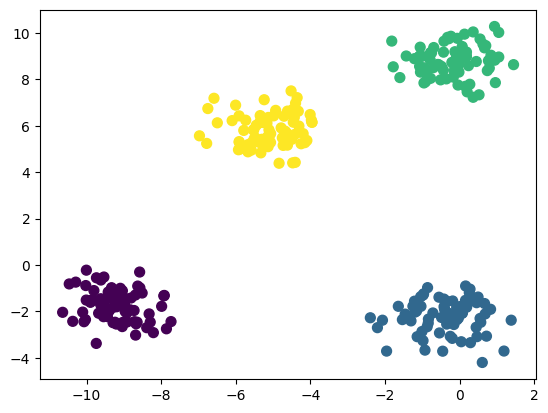

In [20]:
k = 4

S = get_similarity(X_blobs,  gamma=1)
W =  get_adjacency(S) 
kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, k)


y_blobs_pred = kmeans.labels_
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], s=50, c=y_blobs_pred);

Next, we also apply spectral clustering to the two circles case.

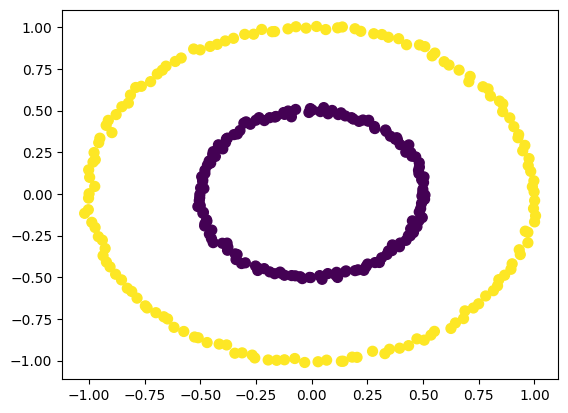

In [21]:
k = 2

S = get_similarity(X_circles,  gamma=30)
W =  get_adjacency(S) 
kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, k)

y_circles_pred = kmeans.labels_
plt.scatter(X_circles[:, 0], X_circles[:, 1], s=50, c=y_circles_pred);

We observe that spectral clustering is able to retrieve the correct cluster assighments.

Similar to K-Means clustering, we also need to determine the number of clusters for spectral clustering beforehand. To find the optimal number of clusters, we can use the eigengap heuristic or the Silhouette score.

In [22]:
def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    
    :param n_clusters_list: List of number of clusters to explore 
    :param metric_dictionary: 
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(3, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1



def get_heuristics_spectral(A, n_clusters_list, plot=True):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering
    
    :param A: affinity matrix
    :param n_clusters_list: List of number of clusters to explore
    :plot: bool, plot the metrics if true
    """
    silhouette_list = []
    distortion_list = []
    bic_list = []
    eigengap_list = []
    davies_bouldin_list = []

    for k in n_clusters_list:

        kmeans, proj_X, eigenvals_sorted = spectral_clustering(A, k)
        y_pred = kmeans.labels_

        if k == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)


    metric_dictionary = {
                         'Silhouette': silhouette_list,
                         'Eigengap': eigenvals_sorted,
                        }
    
    if(plot):
        plot_metrics(n_clusters_list, metric_dictionary)
    else:
        return metric_dictionary

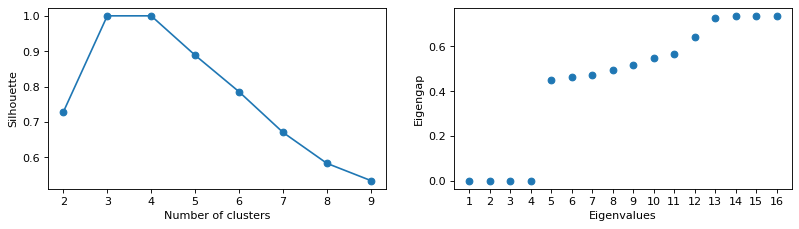

In [23]:
S = get_similarity(X_blobs,  gamma=1)
W =  get_adjacency(S) 
get_heuristics_spectral(W, n_clusters_list)

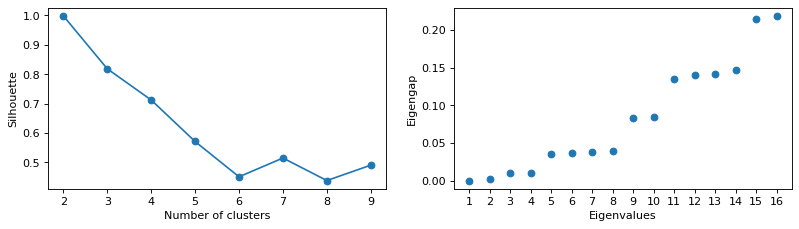

In [24]:
S = get_similarity(X_circles,  gamma=30)
W =  get_adjacency(S) 
get_heuristics_spectral(W,n_clusters_list)

We observe that we find again the correct number of clusters with both of the heuristics.

## Spectral Clustering on Flipped Classroom Data

Given the favorable properties of spectral clustering, we will use it to cluster the students of our flipped classroom data set. We first parse and preprocess the data.

In [25]:
df = pd.read_csv('{}/aggregated_extended_fc.csv'.format(DATA_DIR))
df = df.fillna('NaN')
df.head()

,user,ch_num_sessions,ch_time_in_prob_sum,ch_time_in_video_sum,ch_ratio_clicks_weekend_day,ch_total_clicks_weekend,ch_total_clicks_weekday,ch_time_sessions_mean,ch_time_sessions_std,bo_delay_lecture,...,la_weekly_prop_watched_mean,la_weekly_prop_interrupted_mean,la_weekly_prop_interrupted_std,la_weekly_prop_replayed_mean,la_weekly_prop_replayed_std,la_frequency_action_video_play,grade,gender,category,year
0,0,1.9,2334.4,2951.8,0.850000,16.8,38.1,1392.858333,790.762032,55068.387500,...,0.245714,0.024286,0.0,0.010000,0.0,0.179203,4.50,NaN,NaN,Y2-2018-19
1,1,3.4,1698.4,9227.8,0.567500,4.0,179.4,3068.720238,1257.504407,-2883.367738,...,0.748868,0.074683,0.0,0.066456,0.0,0.332424,4.50,M,Suisse.Autres,Y2-2018-19
2,2,5.3,2340.6,10801.3,26.562274,94.6,129.2,1750.289268,1024.134043,10027.216667,...,0.354487,0.026667,0.0,0.059915,0.0,0.284407,5.25,M,Suisse.PAM,Y2-2018-19
3,3,2.8,2737.1,8185.5,3.691250,13.5,46.4,20203.590260,656.052901,27596.864484,...,0.370000,0.014286,0.0,0.020000,0.0,0.108774,4.50,F,Suisse.Autres,Y2-2018-19
4,4,2.5,3787.3,7040.0,1.543889,58.4,64.9,3373.908333,1363.320365,-914.633333,...,0.030000,0.000000,0.0,0.020000,0.0,0.199775,4.75,F,France,Y2-2018-19


Specifically, we are interested in clustering the students based on their behavior in the course. We investigate two different type of behaviors. The first behavior is related to students effort. We use the following three features as indicators: `ch_time_in_prob_sum`, `ch_time_in_video_sum`, `ch_total_clicks_weekend`, `ch_total_clicks_weekday`. We sum up the time in problems and videos to obtain the total time spent on the platform. Similarly, we also sum up the number of clicks in problems and videos to obtain the total number of clicks.

In [26]:
df['ch_time_sum'] = df.ch_time_in_prob_sum + df.ch_time_in_video_sum
df['ch_total_clicks'] = df.ch_total_clicks_weekend + df.ch_total_clicks_weekday

We first standardize the data.

In [27]:
# Data standardization
data = StandardScaler().fit_transform(df[['ch_time_sum', 'ch_total_clicks']])
time = data[:, [0]]
clicks = data[:, [1]]

Next, we compute pairwise similarity matrices separately for each feature using a Gaussian kernel. We then sum up the two similarity matrices.

In [28]:
S1 = pairwise_kernels(time, metric='rbf', gamma=5)
S2 = pairwise_kernels(clicks, metric='rbf', gamma=5)
S = (S1 + S2) / 2

We then compute the adjacency matrix W.

In [29]:
W = get_adjacency(S)

Finally, we perform a spectral clustering for k=2,...,10 and compute the Silhouette score as well as the eigengap heuristic.

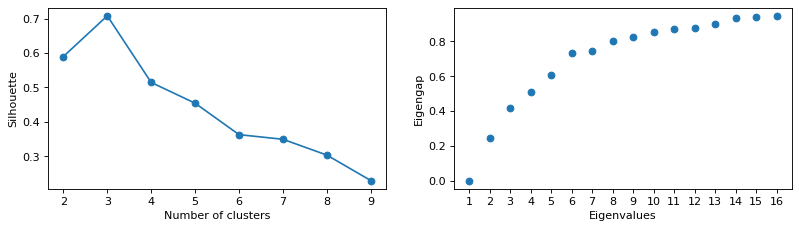

In [30]:
get_heuristics_spectral(W, n_clusters_list)

We see that the metrics indicate that the optimal number for is 3 according to the Silhouette score. The eigengap heuristic is not as clear, 2 seems to be the optimal choice.

The second behavior is related to students proactivity in the course. Use the following two features as indicators of how proactive the students are: `ma_content_anti`, `bo_delay_lecture`. We follow the exact same steps to obtain the spectral clustering and heuristics for this second feature group.

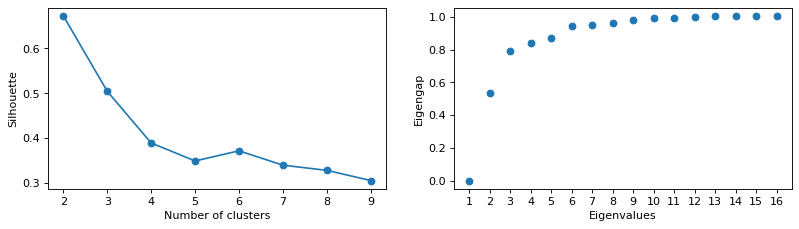

In [31]:
def visualize_clusters(df, f1_name, f2_name):
    data = StandardScaler().fit_transform(df[[f1_name, f2_name]])
    f1 = data[:, [0]]
    f2 = data[:, [1]]

    S1 = pairwise_kernels(f1, metric='rbf', gamma=1)
    S2 = pairwise_kernels(f2, metric='rbf', gamma=1)
    S = (S1 + S2) / 2

    get_heuristics_spectral(S, n_clusters_list)
    
visualize_clusters(df, 'ma_content_anti', 'bo_delay_lecture')

In this example, both heuristics agree that 2 is the optimal number of clusters.